In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import sys
sys.path.append("../../../../../src/")
import nanonets_utils
import nanonets
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
plt.style.use(["science","bright"])

cm  = plt.get_cmap('cividis')
ma  = ["o","s","^","v","<",">"]

In [46]:
# folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/dc_input_vs/"
folder                  = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_two_step_input/"
U_0                     = 0.1
Ne                      = 2
N_voltages              = 10000
t_vals                  = np.arange(N_voltages-1)*1e-10*1e9
steps_between_storage   = [0,2,4,6,8,10,12,14,16,18,20,25,30,40,60,80,100,120,160,180,200,300,400,500,750,1000,2000,3000,4000,5000]
data                    = {steps : pd.read_csv(f"{folder}Nx=9_Ny=9_Nz=1_Ne={Ne}_{steps}.csv") for steps in steps_between_storage}
pot                     = {steps : pd.read_csv(f"{folder}mean_state_Nx=9_Ny=9_Nz=1_Ne={Ne}_{steps}.csv") for steps in steps_between_storage}

In [47]:
stop    = 3000
t_true  = t_vals.copy()[:stop]
y_true  = data[0]['Current'].values[:stop]*1000

In [48]:
def multi_exp_saturation(t, *params):
    t0              = params[0]
    t_shift         = np.clip(t - t0, 0, None)
    # t_shift         = t - t0
    n_components    = (len(params)-1) // 2
    results         = np.zeros_like(t, dtype=float)
    for i in range(n_components):
        a_i     =   params[1+2*i]
        tau_i   =   params[1+2*i+1]
        results +=  a_i * (1 - np.exp(-t_shift/tau_i))
    return results

N               = 5
p0              = [1 for _ in range(2*N+1)]
p_true, c_true  = curve_fit(multi_exp_saturation, t_true, y_true, p0=p0, maxfev=100000)
t0_true         = p_true[0]

def scaled_exp_saturation(t, lam, t0):
    t_shift         = np.clip(t - t0, 0, None)
    # t_shift         = t - t0
    n_components    = (len(p_true)-1) // 2
    results         = np.zeros_like(t, dtype=float)
    for i in range(n_components):
        a_i     =   p_true[1+2*i]
        tau_i   =   p_true[1+2*i+1]
        results +=  a_i * (1 - np.exp(-lam*t_shift/tau_i))

    return results

# def multi_exp_saturation(t, a0, tau0, beta, t0):
#     t_shift = np.clip(t - t0, 0, None)
#     return a0*(1-np.exp(-(t_shift/tau0)**beta))

# p_true, c_true  = curve_fit(multi_exp_saturation, t_true, y_true, bounds=(0,np.inf), maxfev=10000)

# def scaled_exp_saturation(t, lam, t0):
#     t_shift = np.clip(t - t0, 0, None)
#     return p_true[0]*(1-np.exp(-lam*(t_shift/p_true[1])**p_true[2]))

p_true

array([ 4.55098825e+00,  5.72585200e+01,  2.40581510e+01,  2.14623716e+04,
        8.62623268e+04,  2.24423252e+04,  1.05148913e+05,  3.72681528e+01,
       -1.63012121e+02, -3.68006856e+00, -9.15571778e+01])

Text(0.5, 0, '$t$ [ns]')

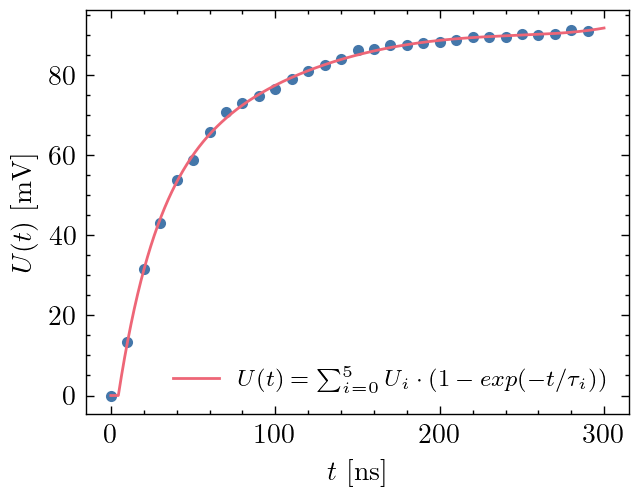

In [49]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(t_true, y_true, '.', markevery=100)
ax.plot(t_true, multi_exp_saturation(t_true, *p_true), label='$U(t)=\\sum_{i=0}^5 U_i\cdot(1-exp(-t/\\tau_i))$')
ax.legend(fontsize='small')
ax.set_ylabel("$U(t)$ [mV]")
ax.set_xlabel("$t$ [ns]")

In [50]:
steps_per_step  = 1500
step_idx        = [[0,steps_per_step,steps_per_step+steps,2*steps_per_step+steps] for steps in steps_between_storage]
start           = 0

t   = t_vals[start:step_idx[0][3]]
y   = data[0].iloc[step_idx[0][0]+start:step_idx[0][3]]['Current'].values*1000
p,c = curve_fit(scaled_exp_saturation, t, y, maxfev=10000, bounds=(0, np.inf))

t1  = t_vals[start:step_idx[0][1]]
y1  = data[0].iloc[step_idx[0][0]+start:step_idx[0][1]]['Current'].values*1000
t2  = t_vals[step_idx[0][2]:step_idx[0][3]]
y2  = data[0].iloc[step_idx[0][2]:step_idx[0][3]]['Current'].values*1000

# p1,c1   = curve_fit(scaled_exp_saturation, t1, y1, maxfev=10000, bounds=((0,t0_true-1e-6), (np.inf,t0_true+1e-6)), p0=[1,t0_true])
p1,c1   = curve_fit(scaled_exp_saturation, t1, y1, maxfev=10000)
# p2,c2   = curve_fit(scaled_exp_saturation, t2, y2, maxfev=10000, bounds=((0,t0_true-1e-6), (np.inf,t0_true+1e-6)), p0=[1,t0_true])
p2,c2   = curve_fit(scaled_exp_saturation, t2, y2, maxfev=10000)

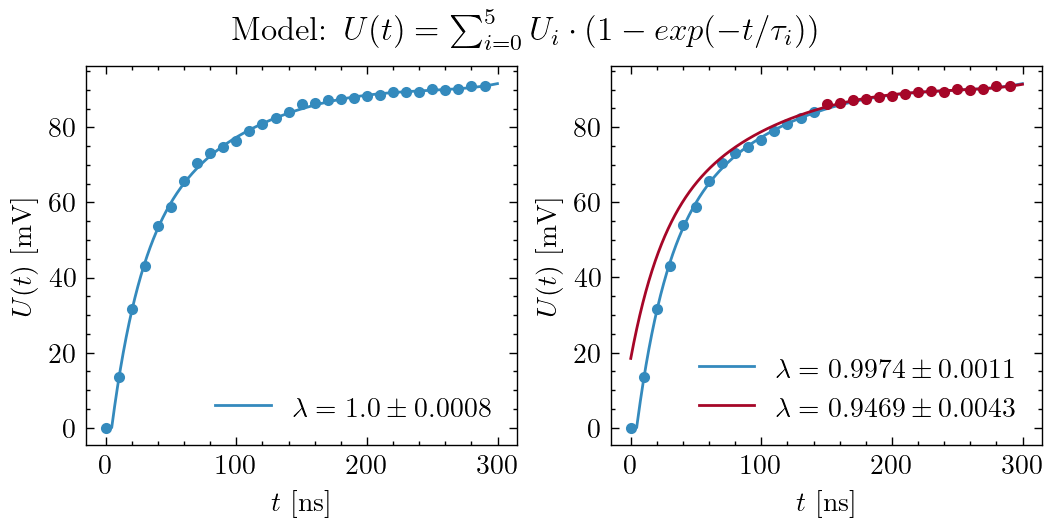

In [51]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
ax  = fig.add_subplot(1,2,1)
ax.plot(t, y, '.', markevery=100, color=nanonets_utils.blue_color)
ax.plot(t, scaled_exp_saturation(t,*p), color=nanonets_utils.blue_color,
        label=f"$\\lambda = {np.round(p[0],4)} \pm {np.round(np.sqrt(c[0,0]),4)}$")
ax.legend()
ax.set_ylabel("$U(t)$ [mV]")
ax.set_xlabel("$t$ [ns]")

ax  = fig.add_subplot(1,2,2)
ax.plot(t1, y1, '.', markevery=100, color=nanonets_utils.blue_color)
ax.plot(t, scaled_exp_saturation(t,*p1), color=nanonets_utils.blue_color,
        label=f"$\\lambda = {np.round(p1[0],4)} \pm {np.round(np.sqrt(c1[0,0]),4)}$")
ax.plot(t2, y2, '.', markevery=100, color=nanonets_utils.red_color)
ax.plot(t, scaled_exp_saturation(t,*p2), color=nanonets_utils.red_color,
        label=f"$\\lambda = {np.round(p2[0],4)} \pm {np.round(np.sqrt(c2[0,0]),4)}$")
ax.set_ylabel("$U(t)$ [mV]")
ax.set_xlabel("$t$ [ns]")
ax.legend()

fig.suptitle("Model: $U(t)=\\sum_{i=0}^5 U_i\cdot(1-exp(-t/\\tau_i))$")
fig.savefig("fit.png")

In [52]:
params1 = []
params2 = []
tau1    = []
tau2    = []
t1_vals = []
t2_vals = []
y1_vals = []
y2_vals = []
start   = 0

for i, (key, df) in enumerate(data.items()):
    y   = df['Current'].values*1000

    # First range
    t1  =   t_vals.copy()[step_idx[i][0]+start:step_idx[i][1]]
    y1  =   y.copy()[step_idx[i][0]+start:step_idx[i][1]]
    # p1,_=   curve_fit(scaled_exp_saturation, t1, y1, bounds=((0,t0_true-1e-6),(np.inf,t0_true+1e-6)))
    p1,_=   curve_fit(scaled_exp_saturation, t1, y1, maxfev=10000)
    tau1.append(p1[0])
    t1_vals.append(t1)
    y1_vals.append(y1)
    params1.append(p1)

    # Second range
    t2  =   t_vals.copy()[step_idx[i][2]+start:step_idx[i][3]]
    y2  =   y.copy()[step_idx[i][2]+start:step_idx[i][3]]
    # p2,_=   curve_fit(scaled_exp_saturation, t2, y2, bounds=((0,t0_true+steps_between_storage[i]/10-1e-6),(np.inf,t0_true+steps_between_storage[i]/10+1500+1e-6)))
    p2,_=   curve_fit(scaled_exp_saturation, t2, y2, maxfev=10000)
    tau2.append(p2[0])
    t2_vals.append(t2)
    y2_vals.append(y2)
    params2.append(p2)

tau_df                      = pd.DataFrame([tau1,tau2],index=["$\\tau_1$","$\\tau_2$"], columns=np.array(steps_between_storage)/10).T
tau_df["$\Delta \\tau$"]    = np.abs(tau_df["$\\tau_2$"] - tau_df["$\\tau_1$"])
tau_df

,$\tau_1$,$\tau_2$,$\Delta \tau$
0.0,0.997384,0.946871,0.050513
0.2,1.014471,0.926629,0.087843
0.4,1.010175,0.377785,0.632390
0.6,1.001834,0.549730,0.452104
0.8,1.008894,1.062874,0.053980
1.0,1.014654,0.985402,0.029252
1.2,1.005339,0.762145,0.243195
1.4,1.012250,0.916049,0.096201
1.6,1.010990,0.661365,0.349625
1.8,1.008324,0.761218,0.247106


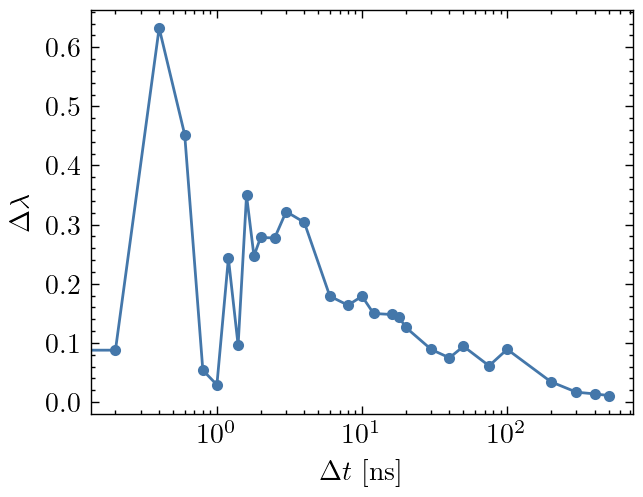

In [53]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(tau_df.index,tau_df.iloc[:,2], '.-')
ax.set_xscale('log')
# ax.set_xlim(0,1000)
# ax.set_ylim(0,0.01)
ax.set_xlabel("$\Delta t$ [ns]")
ax.set_ylabel("$\Delta \\lambda$")
fig.savefig(f"../plots/dc_input/delta_lam_vs_delta_t.svg", transparent=True)

Text(0.5, 0, '$t$ [ns]')

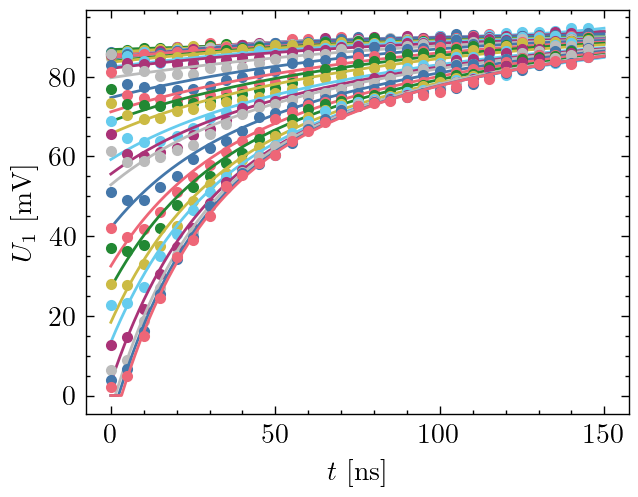

In [54]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for idx in range(len(t2_vals)):
    p = ax.plot(t1_vals[idx], y2_vals[idx], '.', markevery=50)
    ax.plot(t1_vals[idx], scaled_exp_saturation(t2_vals[idx],*params2[idx]), color=p[0].get_color())

    # p = ax.plot(t2_vals[idx], y2_vals[idx], '.', markevery=500)
    # ax.plot(t2_vals[idx], scaled_exp_saturation(t2_vals[idx],*params2[idx]), color=p[0].get_color())
ax.set_ylabel("$U_1$ [mV]")
ax.set_xlabel("$t$ [ns]")
# ax.set_ylim(0,85)
# ax.set_xscale('log')
# fig.savefig(f"../plots/dc_input/2_electrodes/fit_2.svg", transparent=True)

Text(0, 0.5, '$t_0-t_{step}$ [ns]')

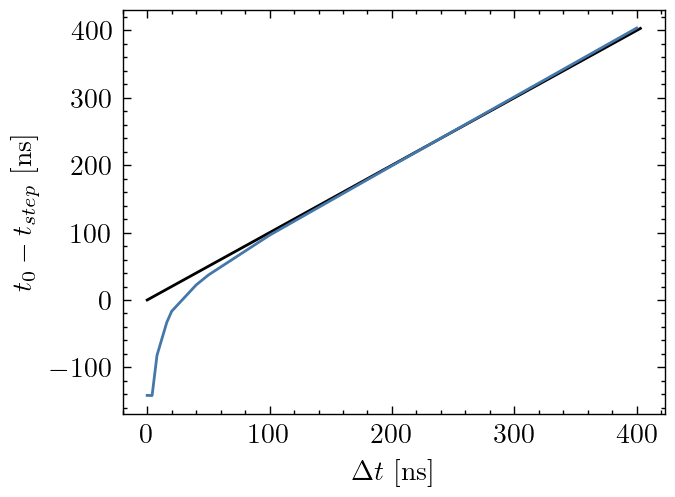

In [25]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(tau_df.index,np.array(params2)[:,1]-150)
ax.plot(np.arange(0,np.max(np.array(params2)[:,1])-150), np.arange(0,np.max(np.array(params2)[:,1])-150), c='black', zorder=1)
# ax.set_xscale('log')
ax.set_xlabel("$\Delta t$ [ns]")
ax.set_ylabel("$t_0-t_{step}$ [ns]")

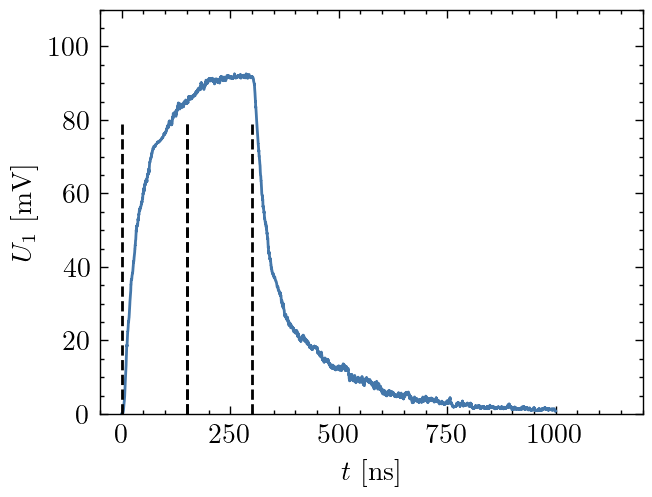

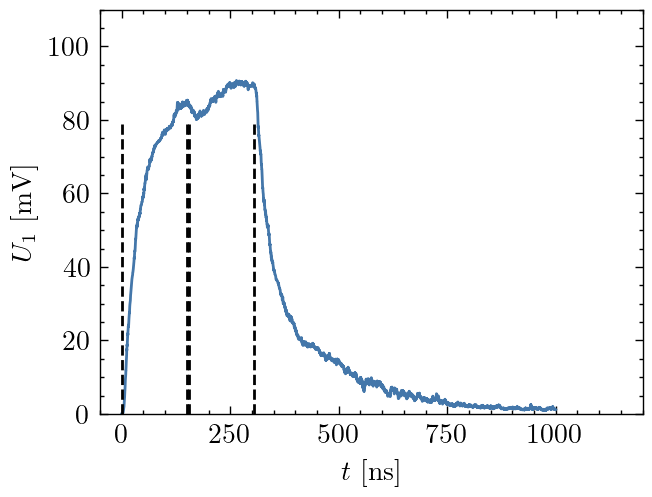

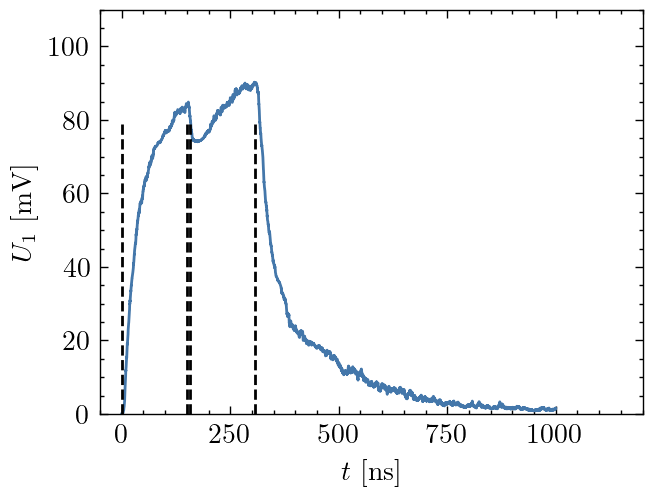

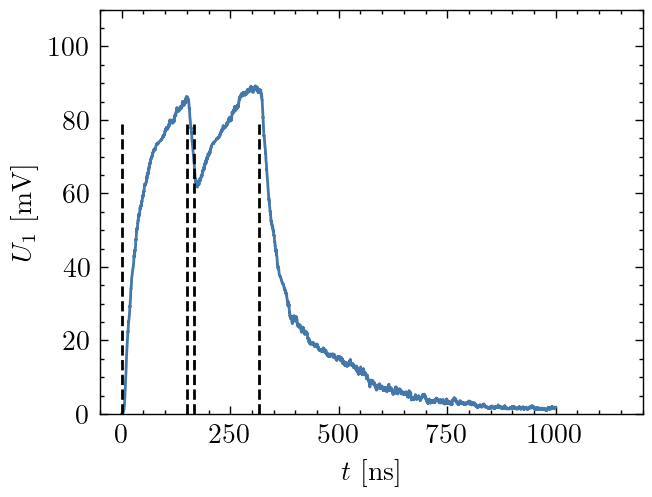

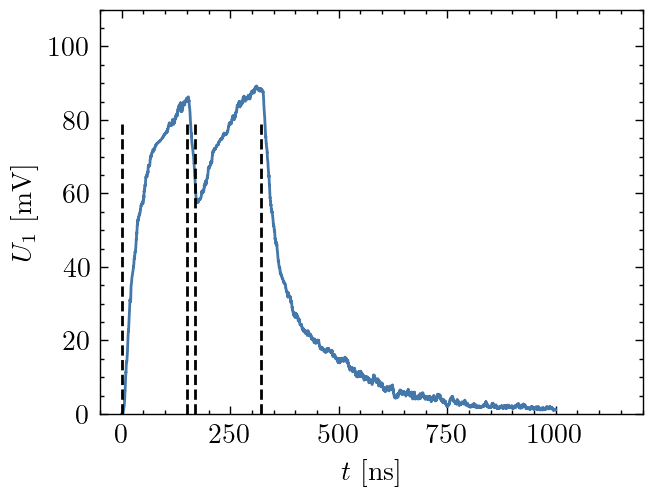

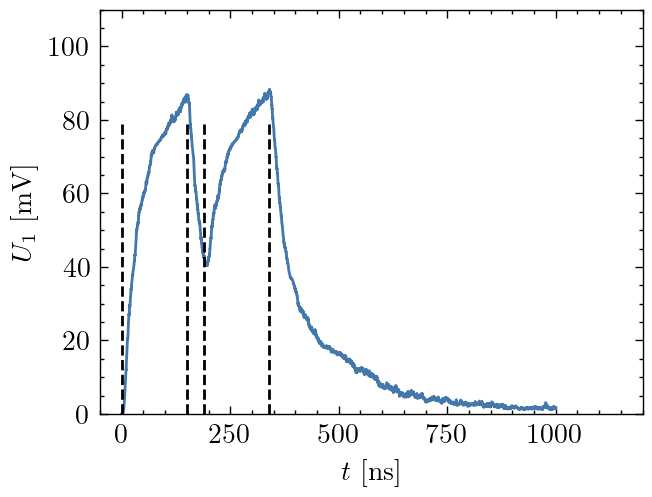

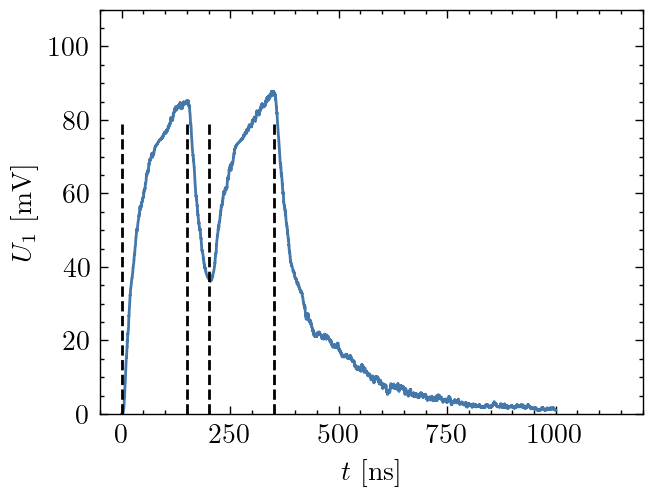

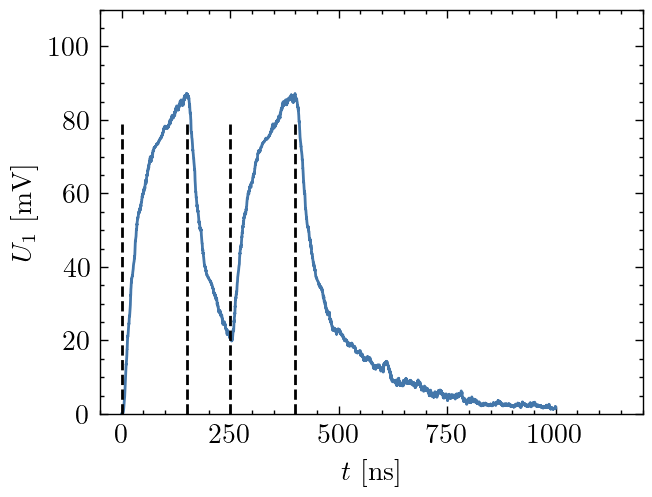

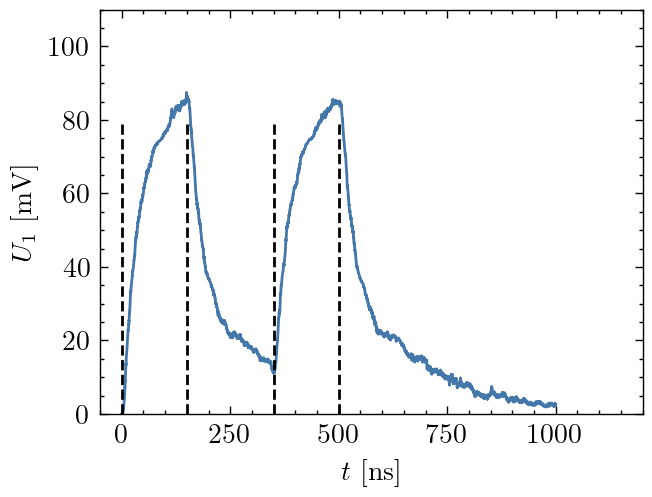

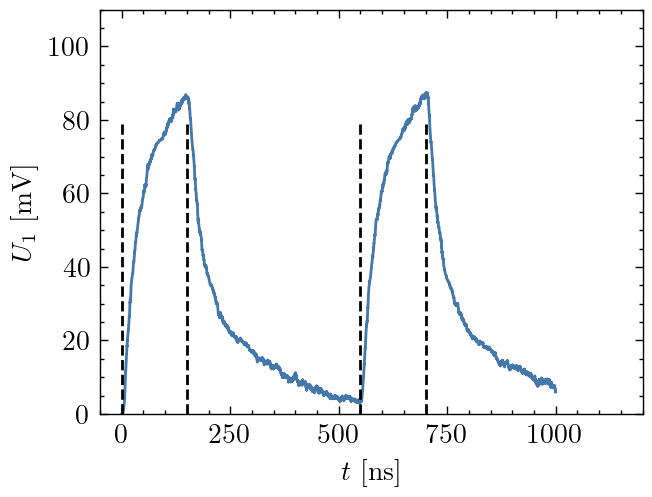

In [29]:
for steps in steps_between_storage:

    y_min   = 0
    y_max   = 120
    idx     = np.where(steps==np.array(steps_between_storage))[0][0]
    fig     = plt.figure(dpi=200)
    ax      = fig.add_subplot()
    y       = data[steps]['Current'].values*1000
    y_e     = data[steps]['Error'].values*1000

    ax.plot(t_vals, y)
    ax.vlines(t_vals[step_idx[idx]], ymin=y_min, ymax=y_max-40, color='black', ls='--')
    ax.set_ylim(y_min, y_max-10)
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$U_1$ [mV]")
    ax.set_xlim(-50,1200)
    
    # fig.savefig(f"../plots/dc_input/2_electrodes/two_steps/response_{steps}.svg", transparent=True)

---

In [2]:
N_voltages          = 10000
time_step           = 1e-10
time_steps          = np.arange(N_voltages)*time_step*1e9
U_0                 = 0.1 #0.02
folder_nonlinear    = "/home/j/j_mens07/phd/data/2_funding_period/current/wo_magic_cable/dc_two_step_input/"
relaxation_time     = 30e-9
steps_per_step      = int(np.round(relaxation_time/time_step))
time_between        = [0,1e-9,2e-9,4e-9,8e-9,16e-9,32e-9,64e-9,128e-9,256e-9]
steps_between       = [int(np.round(t/time_step)) for t in time_between]
voltages            = []

for i in range(len(time_between)):
    s                                           = steps_between[i]
    volt                                        = np.zeros(N_voltages)
    volt[:steps_per_step]                       = U_0
    volt[steps_per_step+s:2*steps_per_step+s]   = U_0
    voltages.append(volt)

pot_nonlinear       = {step : pd.concat([pd.DataFrame([np.zeros(9*9)]),
                                         pd.read_csv(f"{folder_nonlinear}mean_state_Nx=9_Ny=9_Nz=1_Ne=8_{step}.csv", names=np.arange(81), header=0)],
                                         ignore_index=True) for step in steps_between}
np_center_idx       = [4+9*i for i in range(9)]
step_function_idx   = [[0,steps_per_step,steps_per_step+s,2*steps_per_step+s] for s in steps_between]

(-10.0, 200.0)

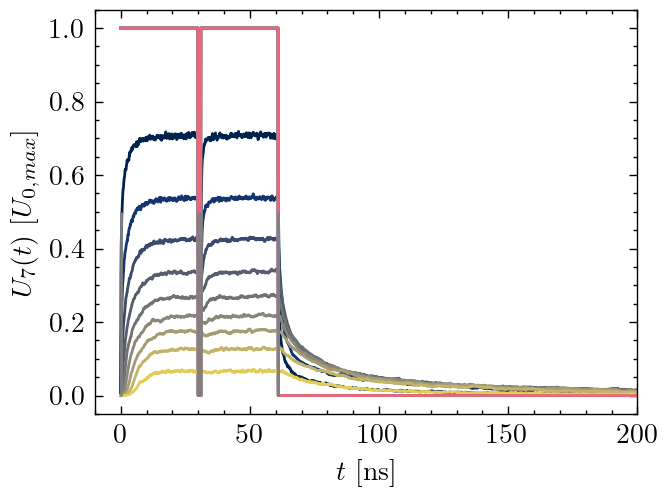

In [3]:
norm    = Normalize(vmin=0, vmax=9)
s_betw  = 10
y_min   = 0
y_max   = 0.5
i_betw  = np.where(np.array(steps_between)==s_betw)[0][0]
x       = voltages[i_betw].copy()/U_0

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

for i_np in range(9):
    y   = pot_nonlinear[s_betw].iloc[:,np_center_idx[i_np]].values/U_0
    ax.plot(time_steps, y, color=cm(norm(i_np)))
    ax.plot(time_steps, x)
    
ax.vlines(x=time_steps[step_function_idx[i_betw]], ymin=y_min, ymax=y_max, colors='grey')
ax.set_ylabel("$U_7(t)$ [$U_{0,max}$]")
ax.set_xlabel("$t$ [ns]")
# ax.set_yscale("log")
# ax.set_ylim(y_min, y_max)
ax.set_xlim(-10,200)

In [4]:
def saturation_cuve(t, tau, a0):
    return a0*(1 - np.exp(-(t) / tau))

def stretched_saturation_curve(t, tau, a0, beta):
    return a0*(1 - np.exp(-((t/tau)**beta)))

func    = stretched_saturation_curve
bounds  = (0,np.inf)
p0      = [3,1,1]

i_NP    = 0
s_betw  = 10
i_betw  = np.where(np.array(steps_between)==s_betw)[0][0]
idx_val = step_function_idx[i_betw]
y       = pot_nonlinear[s_betw].iloc[:,np_center_idx[i_np]].values.copy()
xf1     = time_steps[idx_val[0]:idx_val[1]]
yf1     = y[idx_val[0]:idx_val[1]]
xf2     = time_steps[idx_val[2]:idx_val[3]]
yf2     = y[idx_val[2]:idx_val[3]]
yf2     = yf2 - yf2[0]
p1, _   = curve_fit(func, xf1, yf1, bounds=bounds, p0=p0)
p2, _   = curve_fit(func, xf1, yf2, bounds=bounds, p0=p0)

print(p1)
print(p2)

[9.05328845e+00 6.58560593e-03 2.47572999e+00]
[8.67664865e+03 2.83040559e-02 7.85466081e-01]


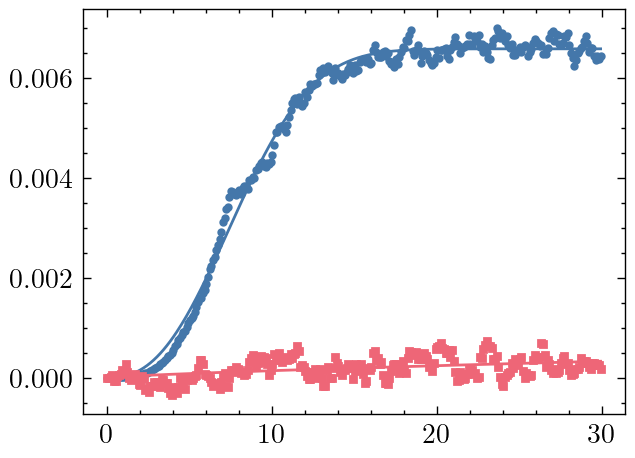

In [5]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
p   = ax.plot(xf1, yf1, 'o', ms=2)
ax.plot(xf1, func(xf1,*p1), color=p[0].get_color())
p   = ax.plot(xf1, yf2, 's', ms=2)
ax.plot(xf1, func(xf1,*p2), color=p[0].get_color())

# plt.plot(xf1, yf1)
# plt.plot(xf1, func(xf1,*p1))
# plt.plot(xf2, yf2)
# plt.plot(xf2, func(xf1,*p2))
# plt.plot(time_steps, y, alpha=0.5)
# plt.xlim(0,100)